In [1]:
import itertools
import mthree
import numpy as np
import os
import matplotlib.pyplot as plt
from qiskit import Aer, transpile
from qiskit_nature.circuit.library import FermionicGaussianState
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from mzm_generation import (
    bdg_hamiltonian,
    compute_edge_correlation,
    compute_edge_correlation_measurement_corrected,
    compute_energy,
    compute_energy_measurement_corrected,
    edge_correlation_op,
    expectation,
    KitaevHamiltonianTask,
    kitaev_hamiltonian,
    load,
    MeasurementErrorCalibrationTask)

In [2]:
# boilerplate
converter = QubitConverter(mapper=JordanWignerMapper())
simulator_backend = Aer.get_backend("statevector_simulator")

In [3]:
# set parameters

# number of modes
n_modes = 3

# x values
num = 20
x_min = 1e-8
x_max = 3.1
x_values = np.linspace(x_min, x_max, num=num)

# number of shots
shots = 10000

# number of shots for measurement error calibration
measurement_error_calibration_shots = 50000

# qubits
qubits = [0, 1, 2]

# experiment id used for saving data
experiment_id = '2022-01-11T16:50:30.417884_ibmq_manila'

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

# load measurement error calibration
task = MeasurementErrorCalibrationTask(experiment_id, shots=measurement_error_calibration_shots)
mit = mthree.M3Mitigation()
mit.cals_from_file(f'data/{task.filename}.json')

In [4]:
# analyze results for Hamiltonian expectation
exact_even_series = np.zeros((num, 2**(n_modes - 1)))
exact_odd_series = np.zeros((num, 2**(n_modes - 1)))
experiment_even_series = np.zeros((num, 2**(n_modes - 1)))
experiment_odd_series = np.zeros((num, 2**(n_modes - 1)))
measurement_corrected_even_series = np.zeros((num, 2**(n_modes - 1)))
measurement_corrected_odd_series = np.zeros((num, 2**(n_modes - 1)))

for i, chemical_potential in enumerate(x_values):
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    hamiltonian_dense = hamiltonian_jw.to_matrix()
    # compute eigenvalues
    transformation_matrix, orbital_energies, constant = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    energy_shift = -0.5 * np.sum(orbital_energies) - constant
    # compute exact and experimental values
    exact_even_energies = []
    exact_odd_energies = []
    experiment_even_energies = []
    experiment_odd_energies = []
    measurement_corrected_even_energies = []
    measurement_corrected_odd_energies = []
    for n_particles in range(n_modes + 1):
        if n_particles % 2:
            exact_energy_list = exact_odd_energies
            experiment_energy_list = experiment_odd_energies
            measurement_corrected_energy_list = measurement_corrected_odd_energies
        else:
            exact_energy_list = exact_even_energies
            experiment_energy_list = experiment_even_energies
            measurement_corrected_energy_list = measurement_corrected_even_energies
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            # load data
            task = KitaevHamiltonianTask(
                experiment_id=experiment_id,
                n_modes=n_modes,
                tunneling=-1.0,
                superconducting=1.0,
                chemical_potential=chemical_potential,
                occupied_orbitals=occupied_orbitals,
                shots=shots)
            data = load(task)
            measurements = data['measurements']
            # exact energy
            circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
            transpiled_circuit = circuit.decompose()
            state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
            exact_energy = np.real(expectation(hamiltonian_dense, state))
            exact_energy_list.append(exact_energy + energy_shift)
            # experimental energy
            experiment_energy = compute_energy(measurements, hamiltonian_jw)
            experiment_energy_list.append(experiment_energy + energy_shift)
            # experimental energy with measurement error mitigation
            quasis = {pauli_string: mit.apply_correction(counts, qubits) for pauli_string, counts in measurements.items()}
            measurement_corrected_energy = compute_energy_measurement_corrected(
                quasis, hamiltonian_jw)
            measurement_corrected_energy_list.append(measurement_corrected_energy + energy_shift)
    exact_even_series[i] = exact_even_energies
    exact_odd_series[i] = exact_odd_energies
    experiment_even_series[i] = experiment_even_energies
    experiment_odd_series[i] = experiment_odd_energies
    measurement_corrected_even_series[i] = measurement_corrected_even_energies
    measurement_corrected_odd_series[i] = measurement_corrected_odd_energies

/home/kjs/projects/qiskit-nature/qiskit_nature/operators/second_quantization/quadratic_hamiltonian.py:103: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(terms, register_length=self._n_orbitals)


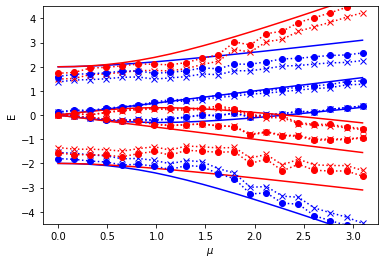

In [5]:
# plot
# TODO save plots
fig, ax = plt.subplots()
for i in range(2**(n_modes - 1)):
    ax.plot(x_values, exact_even_series[:, i], color='blue')
    ax.plot(x_values, exact_odd_series[:, i], color='red')
    ax.plot(x_values, experiment_even_series[:, i], 'x:', color='blue')
    ax.plot(x_values, experiment_odd_series[:, i], 'x:', color='red')
    ax.plot(x_values, measurement_corrected_even_series[:, i], 'o:', color='blue')
    ax.plot(x_values, measurement_corrected_odd_series[:, i], 'o:', color='red')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-4.5, 4.5)
#plt.legend()
plt.savefig(f'plots/{experiment_id}/energy.png', dpi=300)
plt.show()

In [6]:
# analyze results for edge correlation
edge_correlation = edge_correlation_op(n_modes)
edge_correlation_jw = converter.convert(edge_correlation)
edge_correlation_dense = edge_correlation_jw.to_matrix()

edge_corr_exact_even_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_exact_odd_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_experiment_even_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_experiment_odd_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_measurement_corrected_even_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_measurement_corrected_odd_series = np.zeros((num, 2**(n_modes - 1)))

for i, chemical_potential in enumerate(x_values):
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    hamiltonian_dense = hamiltonian_jw.to_matrix()
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    # compute exact and experimental values
    exact_even_correlations = []
    exact_odd_correlations = []
    experiment_even_correlations = []
    experiment_odd_correlations = []
    measurement_corrected_even_correlations = []
    measurement_corrected_odd_correlations = []
    for n_particles in range(n_modes + 1):
        if n_particles % 2:
            exact_correlation_list = exact_odd_correlations
            experiment_correlation_list = experiment_odd_correlations
            measurement_corrected_correlation_list = measurement_corrected_odd_correlations
        else:
            exact_correlation_list = exact_even_correlations
            experiment_correlation_list = experiment_even_correlations
            measurement_corrected_correlation_list = measurement_corrected_even_correlations
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            task = KitaevHamiltonianTask(
                experiment_id=experiment_id,
                n_modes=n_modes,
                tunneling=-1.0,
                superconducting=1.0,
                chemical_potential=chemical_potential,
                occupied_orbitals=occupied_orbitals,
                shots=shots)
            data = load(task)
            measurements = data['measurements']
            # exact correlation
            circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
            transpiled_circuit = circuit.decompose()
            state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
            exact_correlation = np.real(expectation(edge_correlation_dense, state))
            exact_correlation_list.append(exact_correlation)
            # experimental correlation
            experiment_correlation = compute_edge_correlation(measurements)
            experiment_correlation_list.append(experiment_correlation)
            # experimental correlation with measurement error mitigation
            quasis = {pauli_string: mit.apply_correction(counts, qubits) for pauli_string, counts in measurements.items()}
            measurement_corrected_correlation = compute_edge_correlation_measurement_corrected(quasis)
            measurement_corrected_correlation_list.append(measurement_corrected_correlation)
    edge_corr_exact_even_series[i] = exact_even_correlations
    edge_corr_exact_odd_series[i] = exact_odd_correlations
    edge_corr_experiment_even_series[i] = experiment_even_correlations
    edge_corr_experiment_odd_series[i] = experiment_odd_correlations
    edge_corr_measurement_corrected_even_series[i] = measurement_corrected_even_correlations
    edge_corr_measurement_corrected_odd_series[i] = measurement_corrected_odd_correlations

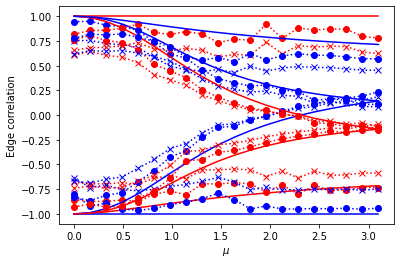

In [7]:
# plot
fig, ax = plt.subplots()
for i in range(2**(n_modes - 1)):
    ax.plot(x_values, edge_corr_exact_even_series[:, i], color='blue')
    ax.plot(x_values, edge_corr_exact_odd_series[:, i], color='red')
    ax.plot(x_values, edge_corr_experiment_even_series[:, i], 'x:', color='blue')
    ax.plot(x_values, edge_corr_experiment_odd_series[:, i], 'x:', color='red')
    ax.plot(x_values, edge_corr_measurement_corrected_even_series[:, i], 'o:', color='blue')
    ax.plot(x_values, edge_corr_measurement_corrected_odd_series[:, i], 'o:', color='red')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Edge correlation')
ax.set_ylim(-1.1, 1.1)
#plt.legend()
plt.savefig(f'plots/{experiment_id}/edge_correlation.png', dpi=300)
plt.show()

In [8]:
# compute BdG Hamiltonian eigenvalues
bdg_series = np.zeros((num, 2 * n_modes))

for i, chemical_potential in enumerate(x_values):
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonian_bdg = bdg_hamiltonian(hamiltonian_quad)
    eigs, _ = np.linalg.eigh(hamiltonian_bdg)
    bdg_series[i] = eigs

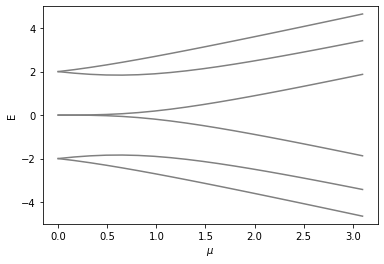

In [9]:
# plot
fig, ax = plt.subplots()

for i in range(2 * n_modes):
    ax.plot(x_values, bdg_series[:, i], color='gray')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()